# Decision Tree Classifier

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
from sklearn import tree
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

## Load Split Data

In [2]:
clean_train = "../../data/clean/clean_train.csv"
clean_val = "../../data/clean/clean_val.csv"
clean_test = "../../data/clean/clean_test.csv"
train_subsam = "../../data/clean/train_subsam.csv"
train_smote = "../../data/clean/train_smote.csv"
dec_tree_model = "../../model/dectree_model.joblib"

rnd_dtc = 44
num_cols = ["Term","NoEmp","SecuredSBA","GrDisburs","GrApprov","ApprovSBA"]
target = "Default"

In [3]:
df_train = pd.read_csv(clean_train, low_memory=False)
df_val = pd.read_csv(clean_val, low_memory=False)
df_test = pd.read_csv(clean_test, low_memory=False)

df_under = pd.read_csv(train_subsam, low_memory=False)
df_smote = pd.read_csv(train_smote, low_memory=False)

In [4]:
X_train = df_train.drop(columns=[target])
X_val = df_val.drop(columns=[target])
X_test = df_test.drop(columns=[target])
X_under = df_under.drop(columns=target)
X_smote = df_smote.drop(columns=target)

y_train = df_train[target]
y_val = df_val[target]
y_test = df_test[target]
y_under = df_under[target]
y_smote = df_smote[target]

In [5]:
print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Val:   {X_val.shape}, {y_val.shape}")
print(f"Test:  {X_test.shape}, {y_test.shape}\n")

print(f"SubSam: {X_under.shape}, {y_under.shape}")
print(f"SMOTE:  {X_smote.shape}, {y_smote.shape}")

Train: (626670, 18), (626670,)
Val:   (134552, 18), (134552,)
Test:  (134498, 18), (134498,)

SubSam: (219654, 18), (219654,)
SMOTE:  (1033686, 18), (1033686,)


## Model Training

### Model Tuning

In [6]:
param_grid = {"criterion": ["gini", "entropy"],
              "max_depth": [None, 10, 20, 30],
              "class_weight": [None, "balanced"],
              "random_state": [rnd_dtc]}

In [7]:
grid_dtc = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=10)
grid_dtc.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'class_weight': [None, 'balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 30],
                         'random_state': [44]})

In [8]:
params = grid_dtc.best_params_

print("Better Parameters:", params)

Better Parameters: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 20, 'random_state': 44}


In [7]:
dtc_model = DecisionTreeClassifier(criterion="entropy",
                                   max_depth=20,
                                   random_state=rnd_dtc)
dtc_model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=20, random_state=44)

In [8]:
acc_val = dtc_model.score(X_val, y_val)

print("Accuracy Val:", round(acc_val, 4))

Accuracy Val: 0.9376


### Feature Importance

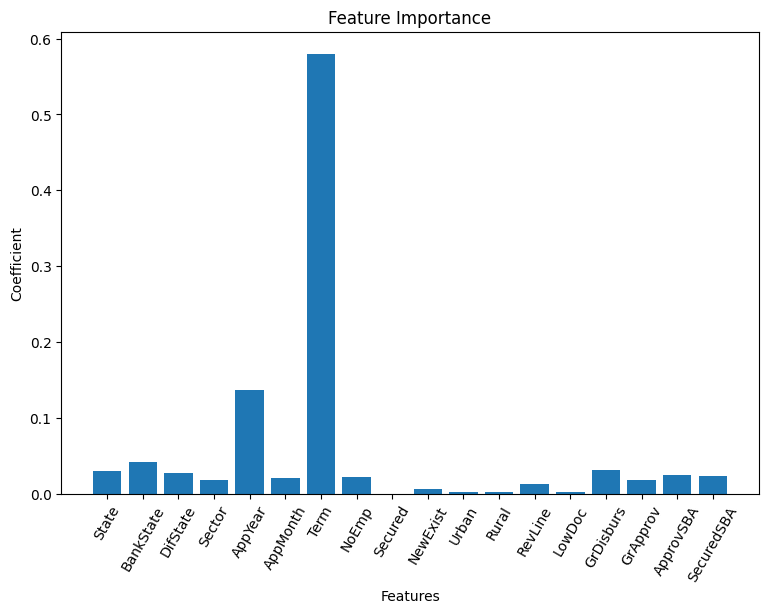

In [9]:
X_cols = X_train.columns
coef_dtc = dtc_model.feature_importances_

plt.figure(figsize=(9, 6))
plt.bar(X_cols, coef_dtc)

plt.title("Feature Importance")
plt.xlabel("Features")
plt.ylabel("Coefficient")
plt.xticks(rotation=60)
plt.show()

### Recursive Feature Elimination

In [10]:
dtc_ref = DecisionTreeClassifier(criterion="entropy",
                                 max_depth=20,
                                 random_state=rnd_dtc)

rfe_dtc = RFE(dtc_ref)
rfe_dtc.fit(X_train, y_train)

RFE(estimator=DecisionTreeClassifier(criterion='entropy', max_depth=20,
                                     random_state=44))

In [11]:
rfe_mat = list(zip(X_train.columns.values.tolist(), rfe_dtc.support_, rfe_dtc.ranking_))
rfe_mat

[('State', True, 1),
 ('BankState', True, 1),
 ('DifState', True, 1),
 ('Sector', False, 4),
 ('AppYear', True, 1),
 ('AppMonth', False, 2),
 ('Term', True, 1),
 ('NoEmp', True, 1),
 ('Secured', False, 10),
 ('NewExist', False, 6),
 ('Urban', False, 7),
 ('Rural', False, 9),
 ('RevLine', False, 5),
 ('LowDoc', False, 8),
 ('GrDisburs', True, 1),
 ('GrApprov', False, 3),
 ('ApprovSBA', True, 1),
 ('SecuredSBA', True, 1)]

In [12]:
sel_cols = [tupla[1] for tupla in rfe_mat]
rfe_cols = X_train.loc[:, sel_cols].columns
rfe_cols

Index(['State', 'BankState', 'DifState', 'AppYear', 'Term', 'NoEmp',
       'GrDisburs', 'ApprovSBA', 'SecuredSBA'],
      dtype='object')

In [13]:
dtc_ref.fit(X_train[rfe_cols], y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=20, random_state=44)

In [14]:
y_ref = dtc_ref.predict(X_val.loc[:,sel_cols])
acc_ref = accuracy_score(y_val, y_ref)

print("Accuracy REF:", round(acc_ref, 4))

Accuracy REF: 0.9379


### Visualizing Decision Tree

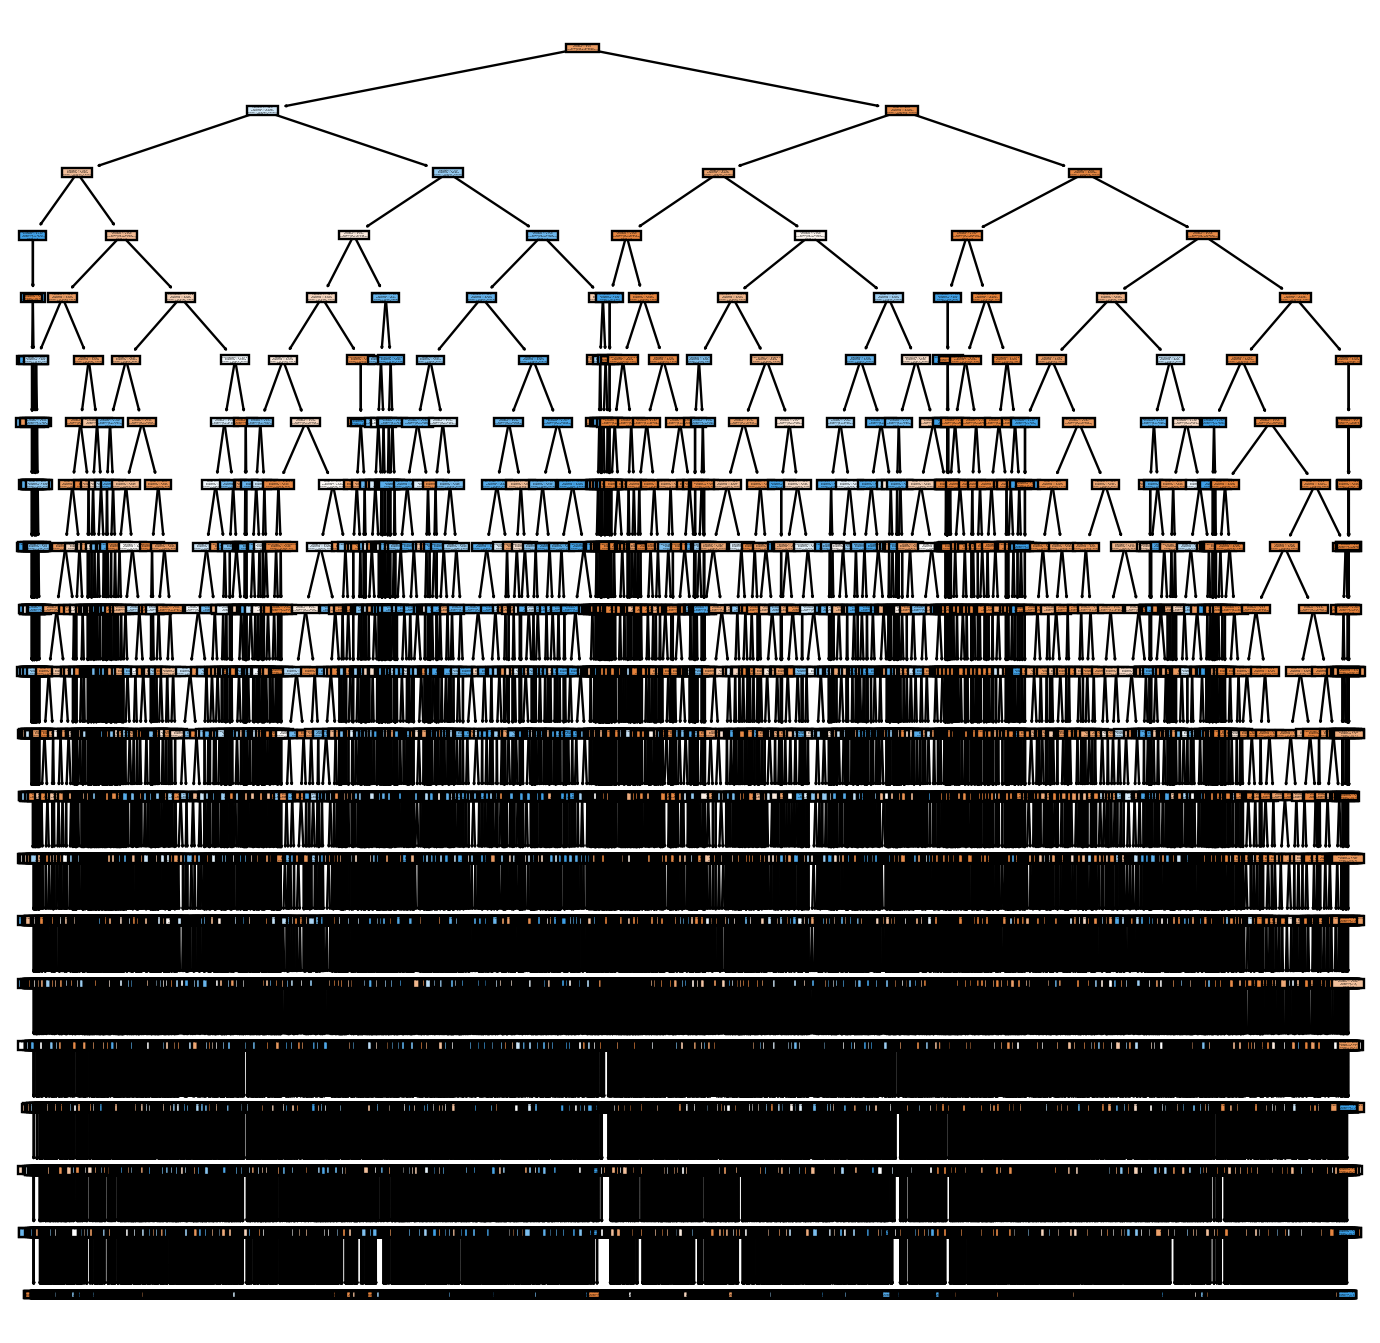

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,10), dpi=170)
tree.plot_tree(dtc_ref,
               feature_names=X_train[rfe_cols].columns,
               class_names=[num for num in range(0, X_train.loc[:, sel_cols].shape[1])],
               filled=True)

### Balanced Datasets

**Subsample Dataset**

In [15]:
dtc_under = DecisionTreeClassifier(criterion="entropy",
                                   max_depth=20,
                                   random_state=rnd_dtc)
dtc_under.fit(X_under[rfe_cols], y_under)

DecisionTreeClassifier(criterion='entropy', max_depth=20, random_state=44)

In [16]:
acc_under = dtc_under.score(X_val[rfe_cols], y_val)

print("Accuracy SubSampling:", round(acc_under, 4))

Accuracy SubSampling: 0.8904


**SMOTE Dataset**

In [17]:
dtc_smote = DecisionTreeClassifier(criterion="entropy",
                                   max_depth=20,
                                   random_state=rnd_dtc)
dtc_smote.fit(X_smote[rfe_cols], y_smote)

DecisionTreeClassifier(criterion='entropy', max_depth=20, random_state=44)

In [18]:
acc_smote = dtc_smote.score(X_val[rfe_cols], y_val)

print("Accuracy SMOTE:", round(acc_smote, 4))

Accuracy SMOTE: 0.8926


## Model Evaluation

### Cross-Validation

**Testing the Model**

In [19]:
results = cross_val_score(dtc_ref, X_test[rfe_cols], y_test, cv=10)

print("Results:", results)
print("Accuracy Test (mean +/- desv): %0.4f +/- %0.4f" % (results.mean(), results.std()))

Results: [0.92297398 0.92334572 0.92460967 0.92289963 0.92304833 0.92245353
 0.92371747 0.92104089 0.92757826 0.9245297 ]
Accuracy Test (mean +/- desv): 0.9236 +/- 0.0016


In [20]:
y_cv_test = cross_val_predict(dtc_ref, X_test[rfe_cols], y_test, cv=10)
acc_cv_test = accuracy_score(y_test, y_cv_test)

print("Accuracy Test:", round(acc_cv_test, 4))

Accuracy Test: 0.9236


**Model Scores**

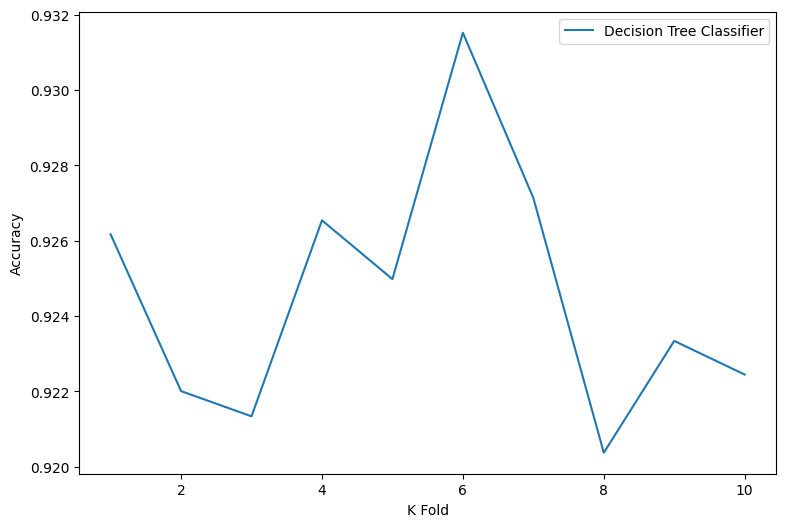

In [21]:
kf = KFold(n_splits=10, shuffle=True)
scores = cross_val_score(dtc_ref, X_test[rfe_cols], y_test, cv=kf, scoring="accuracy")

plt.figure(figsize=(9, 6))
plt.plot(range(1, 11), scores, label="Decision Tree Classifier")

plt.xlabel("K Fold")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Classification Metrics

**Classification Report**

In [22]:
y_pred = dtc_ref.predict(X_test[rfe_cols])

In [23]:
print("Exactitud:    %.4f" % (accuracy_score(y_test, y_pred)))
print("Precisión:    %.4f" % (precision_score(y_test, y_pred, average="macro")))
print("Sensibilidad: %.4f" % (recall_score(y_test, y_pred, average="macro")))
print("F1-score:     %.4f" % (f1_score(y_test, y_pred, average="macro")))

Exactitud:    0.9383
Precisión:    0.8964
Sensibilidad: 0.8908
F1-score:     0.8936


In [24]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9607    0.9645    0.9626    110629
           1     0.8322    0.8170    0.8246     23869

    accuracy                         0.9383    134498
   macro avg     0.8964    0.8908    0.8936    134498
weighted avg     0.9379    0.9383    0.9381    134498



**Confusion Matrix**

In [25]:
cm_dtc = confusion_matrix(y_test, y_pred, normalize="all")
print(cm_dtc)

[[0.79329804 0.02923464]
 [0.03246888 0.14499844]]


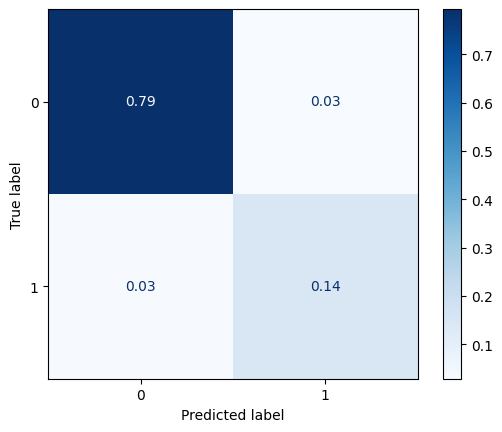

In [26]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_dtc,
                              display_labels=dtc_model.classes_)
disp.plot(cmap="Blues", values_format=".2f")

**ROC (Receiver Operating Characteristic) Curve**

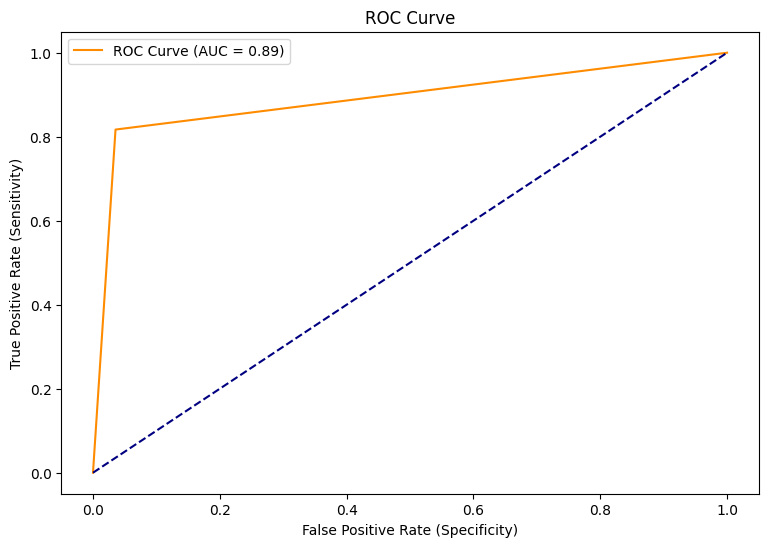

In [27]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(9, 6))
plt.plot(fpr, tpr, color="darkorange", label="ROC Curve (AUC = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")

plt.title("ROC Curve")
plt.xlabel("False Positive Rate (Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.legend()
plt.show()

## Model Pipeline

### Create the Pipeline

In [28]:
class DecisionTreeModel(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.dectree = DecisionTreeClassifier(criterion="entropy",
                                              max_depth=20,
                                              random_state=rnd_dtc)
        self.pred_cols = ["State", "BankState", "DifState", "AppYear", "Term",
                          "NoEmp", "GrDisburs", "ApprovSBA", "SecuredSBA"]

    def fit(self, X, y):
        self.dectree.fit(X[self.pred_cols], y)
        return self

    def predict(self, X, y=None):
        X_ = X[self.pred_cols].copy()
        y_pred = self.dectree.predict(X_)
        return y_pred

In [29]:
dectree_custom = Pipeline([
    ("custom_model", DecisionTreeModel())
    ])

### Test the Pipeline

**Internal Partition**

In [30]:
dectree_custom.fit(X_train, y_train)

y_pred = dectree_custom.predict(X_val)

In [31]:
print("Exactitud:    %.4f" % (accuracy_score(y_val, y_pred)))
print("Precisión:    %.4f" % (precision_score(y_val, y_pred, average="macro")))
print("Sensibilidad: %.4f" % (recall_score(y_val, y_pred, average="macro")))
print("F1-score:     %.4f" % (f1_score(y_val, y_pred, average="macro")))

Exactitud:    0.9379
Precisión:    0.8951
Sensibilidad: 0.8908
F1-score:     0.8930


**External Partition**

In [32]:
X_train_val = pd.concat([X_train, X_val], axis=0)
y_train_val = pd.concat([y_train, y_val], axis=0)

dectree_custom.fit(X_train_val, y_train_val)

y_pred = dectree_custom.predict(X_test)

In [33]:
print("Exactitud:    %.4f" % (accuracy_score(y_test, y_pred)))
print("Precisión:    %.4f" % (precision_score(y_test, y_pred, average="macro")))
print("Sensibilidad: %.4f" % (recall_score(y_test, y_pred, average="macro")))
print("F1-score:     %.4f" % (f1_score(y_test, y_pred, average="macro")))

Exactitud:    0.9389
Precisión:    0.8979
Sensibilidad: 0.8912
F1-score:     0.8945


**The Best Model**

In [34]:
dectree_custom.fit(X_train_val, y_train_val)

y_pred = dectree_custom.predict(X_test)

In [35]:
print("Exactitud:    %.4f" % (accuracy_score(y_test, y_pred)))
print("Precisión:    %.4f" % (precision_score(y_test, y_pred, average="macro")))
print("Sensibilidad: %.4f" % (recall_score(y_test, y_pred, average="macro")))
print("F1-score:     %.4f" % (f1_score(y_test, y_pred, average="macro")))

Exactitud:    0.9389
Precisión:    0.8979
Sensibilidad: 0.8912
F1-score:     0.8945


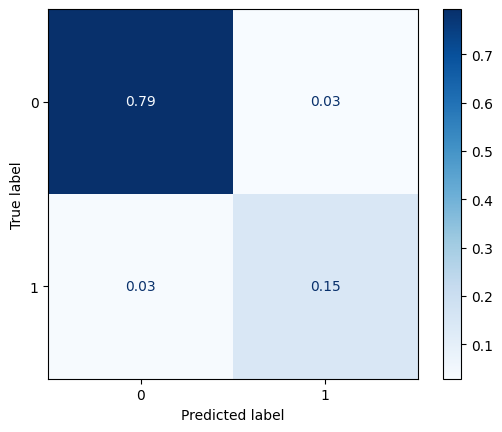

In [36]:
cm_dtc = confusion_matrix(y_test, y_pred, normalize="all")

disp = ConfusionMatrixDisplay(confusion_matrix=cm_dtc,
                              display_labels=dtc_model.classes_)
disp.plot(cmap="Blues", values_format=".2f")

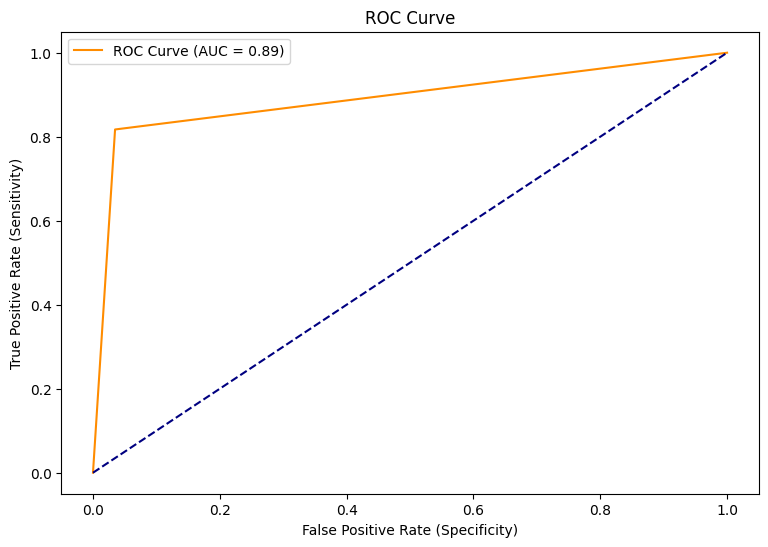

In [37]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(9, 6))
plt.plot(fpr, tpr, color="darkorange", label="ROC Curve (AUC = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")

plt.title("ROC Curve")
plt.xlabel("False Positive Rate (Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.legend()
plt.show()

### Save the Model

In [38]:
try:
    joblib.dump(dectree_custom, dec_tree_model)

    dectree_model = joblib.load(dec_tree_model)
    print(f"Decision Tree Classifier is loaded...")

except Exception as err:
    print("Error:", str(err))

Decision Tree Classifier is loaded...


In [39]:
y_pred = dectree_model.predict(X_test)
df_ = pd.concat([X_test, y_test, pd.DataFrame({"Pred": y_pred})], axis=1)

In [44]:
df_.sample(10)

,State,BankState,DifState,Sector,AppYear,AppMonth,Term,NoEmp,Secured,NewExist,Urban,Rural,RevLine,LowDoc,GrDisburs,GrApprov,ApprovSBA,SecuredSBA,Default,Pred
72256,42,46,0,3,38,7,38,9,0,0,1,0,0,0,250000,250000,187500,75,1,1
76329,43,17,1,0,43,5,84,0,0,1,1,0,0,0,100800,100800,50400,50,0,0
89922,31,37,1,12,44,4,7,6,0,0,1,0,1,0,25000,25000,12500,50,1,1
129081,36,39,0,7,35,4,32,4,0,1,0,0,0,0,205000,205000,153750,75,1,1
36543,9,11,0,20,31,7,300,4,1,1,0,0,0,0,440000,440000,330000,75,0,0
43022,47,40,1,19,37,8,103,7,0,0,0,0,1,0,250000,250000,187500,75,0,1
94893,3,17,1,16,44,8,84,1,0,1,1,0,1,0,29000,25000,12500,50,0,0
77466,4,5,0,20,23,12,240,34,1,0,0,0,0,0,338000,338000,338000,100,0,0
7945,30,33,0,20,31,5,300,3,1,0,0,0,0,0,206500,206500,154875,75,0,0
90126,47,52,0,12,28,9,240,3,1,1,0,0,0,0,460000,460000,391000,85,0,0
